## Instalar bibliotecas necesarias

In [1]:
!pip install torch                    # Install the PyTorch library for deep learning.
!pip install pandas                   # Install the Pandas library for data manipulation.
!pip install scikit-learn             # Install scikit-learn for machine learning tasks.

## Acceder a drive

In [2]:
from google.colab import drive

# Montar Google Drive en /content/drive
drive.mount('/content/drive')

# Listar archivos en el directorio raíz de Google Drive
!ls '/content/drive/MyDrive/Dataset/Mosaico'

Mounted at /content/drive
dataset.csv  Imagenes  test.csv  train.csv


## Bibliotecas

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from torchvision.io import read_image
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader,ConcatDataset
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch import optim
import datetime
from sklearn.preprocessing import StandardScaler

In [4]:
# Definir si viene desde local o drive
ruta = '/content/drive/MyDrive/Dataset/Mosaico/'
# ruta = '../Dataset/Mosaico/'

## Lectura de dataset train y test

In [5]:
train = pd.read_csv(f'{ruta}train.csv')
test = pd.read_csv(f'{ruta}test.csv')

train.head()

,bathrooms,bedrooms,area,zipcode,mosaic_image,price
0,2.0,4,7841,60016,78.png,299000
1,2.5,3,3233,62234,70.png,259000
2,1.0,2,1110,94501,204.png,649000
3,3.0,4,2256,62214,72.png,144900
4,2.0,2,2036,92276,287.png,175000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bathrooms     481 non-null    float64
 1   bedrooms      481 non-null    int64  
 2   area          481 non-null    int64  
 3   zipcode       481 non-null    int64  
 4   mosaic_image  481 non-null    object 
 5   price         481 non-null    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 22.7+ KB


## Preparar Dataset

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Constructor de la clase que inicializa el dataset personalizado.
        df: DataFrame que contiene los datos (rutas de las imágenes y características numéricas).
        transform: Transformaciones opcionales que se aplicarán a las imágenes (si se proporciona).
        """
        self.df = df  # Guardar el DataFrame que contiene las rutas de imágenes y las características numéricas.
        self.transform = transform  # Almacenar las transformaciones opcionales para las imágenes.

        # Seleccionar las columnas que contienen las características numéricas que deseas estandarizar.
        self.numeric_features = ['bedrooms', 'bathrooms', 'area', 'zipcode']

        # Inicializar el estandarizador de sklearn (StandardScaler) y ajustarlo a las características numéricas.
        # Esto normaliza las características para que tengan media 0 y desviación estándar 1.
        self.scaler = StandardScaler()

        # Aplicar el estandarizador a las columnas de características numéricas y actualizar el DataFrame.
        # Las características numéricas se estandarizan y reemplazan en el DataFrame original.
        self.df[self.numeric_features] = self.scaler.fit_transform(self.df[self.numeric_features])

    def __len__(self):
        """
        Método que devuelve la longitud del dataset, es decir, el número de muestras en el DataFrame.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Método que obtiene una muestra del dataset en el índice `idx`.
        Este método es necesario para que el DataLoader pueda iterar sobre el dataset.
        idx: Índice de la muestra a recuperar.

        Devuelve:
        - La imagen procesada (como un tensor).
        - Las características numéricas estandarizadas (como un tensor).
        - El valor objetivo (precio), también convertido a tensor.
        """
        # Obtener la ruta de la imagen correspondiente al índice dado.
        img_path = self.df.loc[idx, 'mosaic_image']

        # Leer la imagen desde el disco utilizando torchvision.io.read_image.
        # Convierte la imagen en un tensor y ajusta su tipo de dato a flotante (float32).
        mosaic_image = read_image(f"{ruta}Imagenes/{img_path}").float()

        # Obtener los valores de las características numéricas para la muestra actual.
        # Convertir estos valores en tensores de tipo float32.
        bathrooms = torch.tensor(self.df.loc[idx, 'bathrooms'], dtype=torch.float32)
        bedrooms = torch.tensor(self.df.loc[idx, 'bedrooms'], dtype=torch.float32)
        area = torch.tensor(self.df.loc[idx, 'area'], dtype=torch.float32)
        zipcode = torch.tensor(self.df.loc[idx, 'zipcode'], dtype=torch.float32)
        price = torch.tensor(self.df.loc[idx, 'price'], dtype=torch.float32)  # Precio como el valor objetivo.

        # Aplicar las transformaciones a la imagen si se proporcionaron en el constructor.
        if self.transform:
            mosaic_image = self.transform(mosaic_image)

        # Concatenar las características numéricas (bathrooms, bedrooms, area, zipcode) en un único tensor.
        # Utilizar torch.hstack para concatenar los tensores a lo largo del eje horizontal.
        numeric_features = torch.hstack((bathrooms, bedrooms, area, zipcode))

        # Devolver la imagen procesada, las características numéricas estandarizadas y el precio objetivo.
        return mosaic_image, numeric_features, price


## Aumentar datos

In [8]:
data = CustomImageDataset(df=train,
                          # transform=transforms.Compose([
                          #     transforms.Normalize(
                          #         (58.0583, 55.1679, 52.9831),                    # Media para normalizar los canales RGB
                          #          (85.9875, 82.3628, 80.8718)                     # Desviación estándar para normalizar
                          #         )
                          #     ])
                          )



## Ver imagenes de cada data

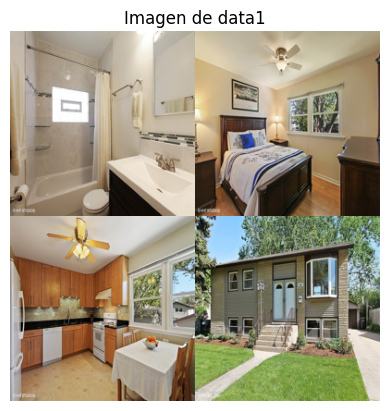

In [9]:
import matplotlib.pyplot as plt
import torch

# Función para deshacer la normalización (inverso de transforms.Normalize)
# def denormalize(tensor, mean, std):
#     mean = torch.tensor(mean).view(3, 1, 1)  # Ajustar la media a la forma del tensor
#     std = torch.tensor(std).view(3, 1, 1)    # Ajustar la desviación estándar a la forma del tensor
#     return tensor * std + mean

# Función para mostrar una imagen
def show_image(image_tensor, title=None):
    # Deshacer la normalización
    # image_tensor = denormalize(image_tensor, mean=(58.0583, 55.1679, 52.9831), std=(85.9875, 82.3628, 80.8718))

    # Asegurarse de que los valores de los píxeles estén entre 0 y 255
    image_tensor = torch.clamp(image_tensor, 0, 255)

    # Convertir el tensor a numpy
    image = image_tensor.permute(1, 2, 0).cpu().numpy()  # Cambia las dimensiones de (C, H, W) a (H, W, C)

    # Mostrar la imagen
    plt.imshow(image.astype('uint8'))  # Convertir los valores a uint8 para que matplotlib pueda mostrarlos correctamente
    if title:
        plt.title(title)
    plt.axis('off')  # Quitar los ejes
    plt.show()

# Visualizar la primera imagen de cada conjunto de datos
datasets = [data]
for i, dataset in enumerate(datasets, 1):
    # Obtener la primera muestra del conjunto de datos (imagen, características numéricas, precio)
    image, _, _ = dataset[0]

    # Mostrar la imagen
    show_image(image, title=f"Imagen de data{i}")


## Dividir en train y test

In [10]:
# Determinar el tamaño de los conjuntos de entrenamiento y validación
valor_train = int(0.9*len(data))
valor_val = len(data)-valor_train

print(f"Train: {valor_train} Val: {valor_val}")


Train: 432 Val: 49


In [11]:
# Dividir el conjunto de datos en conjuntos de entrenamiento y validación
train_data,val_data=torch.utils.data.random_split(data,[valor_train,valor_val])

# Eliminar las variables que ya no se necesitan
del data

In [12]:
# Crear los dataloaders
batch_size=64

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_data)} batches de tamaño {len(train_dataloader)}")
print(f"Val: {len(val_data)} batches de tamaño {len(val_dataloader)}")

Train: 432 batches de tamaño 6
Val: 49 batches de tamaño 1


## Red neuronal

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.image_features_ = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),   # 400x400
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # 200x200
            nn.Dropout(),

            nn.Conv2d(16, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # 100x100
            nn.Dropout(),

            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # 50x50

            nn.Conv2d(128, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # 25x25
        )
        self.numeric_features_ = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64, 64*3),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64*3, 64*3*3),
            nn.ReLU(inplace=True),
        )
        self.combined_features_ = nn.Sequential(
            nn.Linear(37440, 64*3*3*2*2),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(64*3*3*2*2, 64*3*3*2),
            nn.ReLU(inplace=True),

            nn.Linear(64*3*3*2, 64),
            nn.Linear(64, 1),
        )

    def forward(self, x,y):
        x = self.image_features_(x)
        # print(x.shape)
        x=x.view(-1, 64*24*24)
        # print(x.shape)
        y=self.numeric_features_(y)
        # print(y.shape)
        z=torch.cat((x,y),1)
        # print(z.shape)
        z=self.combined_features_(z)
        return z.squeeze(1)

In [14]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

In [15]:
# Definir el dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

# Definir el modelo, la función de pérdida y el optimizador
model = NeuralNetwork().to(device)              # Modelo de red neuronal mandarlo al dispositivo (GPU)

# Optimizador y función de pérdida
optimizer=optim.Adam(model.parameters(),1e-3)   # Adam optimizer para optimización
loss_fn = RMSELoss()                            # RMSE Loss para regresión

Using cuda device


## Ciclos de entrenamiento y pruebas

In [16]:
def evaluate(model, dataloader, loss_fn):
    model.eval()  # Poner el modelo en modo evaluación
    running_loss = 0.0

    with torch.no_grad():  # No calcular gradientes
        for batch_idx, (imgs, numeric_features, target) in enumerate(dataloader):
            imgs = imgs.to(device)
            numeric_features = numeric_features.to(device)
            target = target.to(device)

            # Forward pass: Obtener las predicciones
            output = model(imgs, numeric_features)

            # Calcular la pérdida
            loss = loss_fn(output, target)
            running_loss += loss.item()

    return running_loss / len(dataloader)

In [17]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    train_losses = []
    val_losses = []

    for epoch in range(1, n_epochs + 1):
        model.train()  # Poner el modelo en modo entrenamiento
        running_loss = 0.0

        for batch_idx, (imgs, numeric_features, target) in enumerate(train_loader):
            imgs = imgs.to(device)
            numeric_features = numeric_features.to(device)
            target = target.to(device)

            # Forward pass: Obtener las predicciones del modelo
            optimizer.zero_grad()  # Resetear los gradientes
            output = model(imgs, numeric_features)

            # Calcular la pérdida
            loss = loss_fn(output, target)
            loss.backward()  # Backpropagation
            optimizer.step()  # Actualizar los pesos

            running_loss += loss.item()  # Acumular la pérdida
            print(f"Epoch {epoch}, Batch {batch_idx+1}/{len(train_loader)}, Batch Loss: {loss.item():.4f}")

        train_losses.append(running_loss / len(train_loader))

        # Validación en cada época
        val_loss = evaluate(model, val_loader, loss_fn)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}/{n_epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}")

    return train_losses, val_losses

## Entrenamiento

In [18]:
n_epochs = 400  # Número de épocas

train_losses, val_losses = training_loop(n_epochs, optimizer, model, loss_fn, train_dataloader, val_dataloader)

Epoch 1, Batch 1/6, Batch Loss: 708901.5000
Epoch 1, Batch 2/6, Batch Loss: 781760.8125
Epoch 1, Batch 3/6, Batch Loss: 577657.8125
Epoch 1, Batch 4/6, Batch Loss: 584418.5625
Epoch 1, Batch 5/6, Batch Loss: 360820.2812
Epoch 1, Batch 6/6, Batch Loss: 671289.1250
Epoch 1/400, Training Loss: 614141.3490, Validation Loss: 1020907.9375
Epoch 2, Batch 1/6, Batch Loss: 467420.5312
Epoch 2, Batch 2/6, Batch Loss: 502595.3750
Epoch 2, Batch 3/6, Batch Loss: 745217.0625
Epoch 2, Batch 4/6, Batch Loss: 761829.4375
Epoch 2, Batch 5/6, Batch Loss: 542335.3125
Epoch 2, Batch 6/6, Batch Loss: 580606.8125
Epoch 2/400, Training Loss: 600000.7552, Validation Loss: 1013367.5625
Epoch 3, Batch 1/6, Batch Loss: 252095.3750
Epoch 3, Batch 2/6, Batch Loss: 638880.8125
Epoch 3, Batch 3/6, Batch Loss: 719620.4375
Epoch 3, Batch 4/6, Batch Loss: 463686.8750
Epoch 3, Batch 5/6, Batch Loss: 357654.5938
Epoch 3, Batch 6/6, Batch Loss: 581933.8125
Epoch 3/400, Training Loss: 502311.9844, Validation Loss: 1061941.

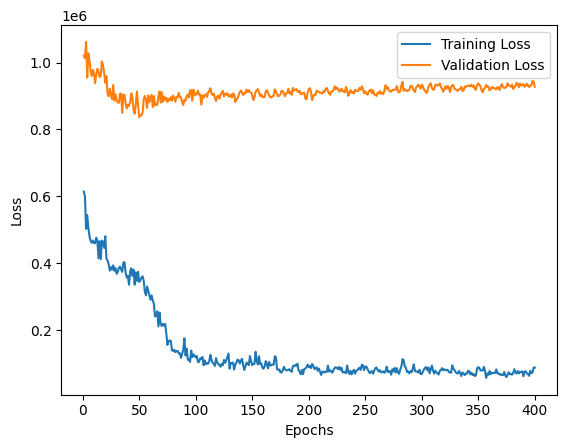

In [19]:
import matplotlib.pyplot as plt

# Graficar las pérdidas
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Probar modelo

In [20]:
# Importar dataset
test = pd.read_csv(f'{ruta}test.csv')
test.head()

,bathrooms,bedrooms,area,zipcode,mosaic_image,price
0,2.5,3,1915,92021,117.png,485000
1,2.5,3,2248,92677,132.png,1199000
2,1.0,3,1132,96019,154.png,170000
3,4.0,6,3375,92880,245.png,538000
4,2.5,3,2733,91901,84.png,689000


In [21]:
# Crear dataset
test_data = CustomImageDataset(df=test)

In [22]:
# Crear dataloader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [25]:
# Predecir precios de casa

def predict(model, test_loader, device):
    model.eval()  # Poner el modelo en modo evaluación
    predictions = []
    actuals = []

    with torch.no_grad():  # Deshabilitar el cálculo de gradientes
        for batch_idx, (imgs, numeric_features, target) in enumerate(test_loader):
            # Mover los datos a la GPU si está disponible
            imgs = imgs.to(device)
            numeric_features = numeric_features.to(device)
            target = target.to(device)

            # Forward pass: obtener las predicciones
            output = model(imgs, numeric_features)

            # Almacenar las predicciones y los valores reales (en CPU para facilidad)
            predictions.append(output.cpu().numpy())
            actuals.append(target.cpu().numpy())

    # Convertir las listas de predicciones y reales en arrays de NumPy
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    return predictions, actuals

In [26]:
# Llamar a la función de predicción
predictions, actuals = predict(model, test_loader, device)

# Mostrar algunas predicciones junto con los valores reales
for i in range(10):  # Mostrar los primeros 10 ejemplos
    print(f"Predicción: {predictions[i]}, Valor real: {actuals[i]}")


Predicción: 260283.96875, Valor real: 485000.0
Predicción: 259105.5625, Valor real: 1199000.0
Predicción: 181379.46875, Valor real: 170000.0
Predicción: 217195.171875, Valor real: 538000.0
Predicción: 436804.9375, Valor real: 689000.0
Predicción: 147297.859375, Valor real: 118900.0
Predicción: 247393.046875, Valor real: 799000.0
Predicción: 282218.96875, Valor real: 895000.0
Predicción: 378372.4375, Valor real: 599000.0
Predicción: 177793.421875, Valor real: 535000.0


In [27]:
# Evaluacion

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"RMSE en el conjunto de prueba: {rmse:.4f}")

# Calcular MAE
mae = mean_absolute_error(actuals, predictions)
print(f"MAE en el conjunto de prueba: {mae:.4f}")


RMSE en el conjunto de prueba: 437869.1875
MAE en el conjunto de prueba: 296318.7188


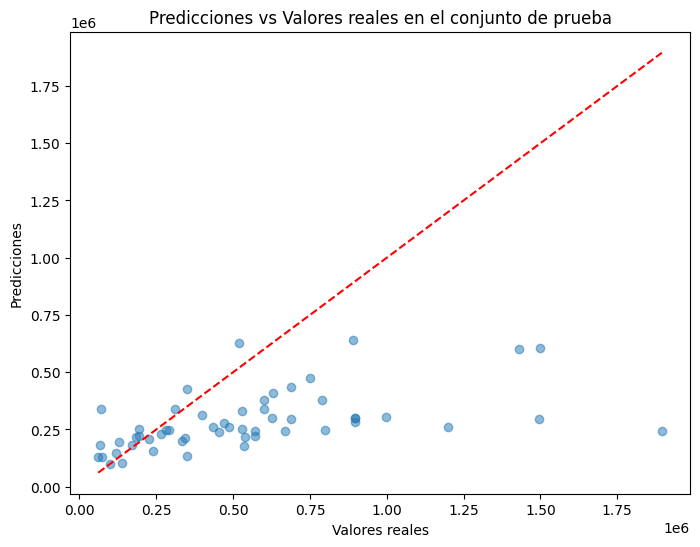

In [29]:
import matplotlib.pyplot as plt

# Graficar las predicciones vs los valores reales
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  # Línea de igualdad (predicción = realidad)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales en el conjunto de prueba')
plt.show()
